In [1]:
import math
import numpy as np

import sys

import plotly.graph_objects as go

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep

from h5flow.data import dereference
import h5flow

# from h5flow.data import dereference
# import h5flow

import numpy as np

import boost_histogram as bh

import hist

import uproot

import os

from scipy.spatial.distance import pdist, squareform, cdist

import awkward as ak

from sklearn.neighbors import KDTree

from sklearn.cluster import DBSCAN

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit

from sklearn.linear_model import LinearRegression

from hist import Hist

import scipy

import numpy.lib.recfunctions as rfn
# import ROOT

Authorization required, but no authorization protocol specified

Invalid MIT-MAGIC-COOKIE-1 key
Authorization required, but no authorization protocol specified

Invalid MIT-MAGIC-COOKIE-1 key
Authorization required, but no authorization protocol specified

Invalid MIT-MAGIC-COOKIE-1 key


In [2]:
# ??DBSCAN

In [3]:
plt.ioff()

In [4]:
def plot_three_views(hits, axs=None, **kwargs):
    #if axs is None:
    #    fig, axs = plt.subplots(2, 2, figsize=(5*2, 5*2))
    #    assert fig == axs[0,0].get_figure()
    #elif isinstance(axs, np.ndarray):
    #    if axs.shape == (2, 2):
    #        fig = axs[0,0].get_figure()
    #    else:
    #        raise TypeError('Axes passed in are not 2x2')
    #else:
    #    raise TypeError('axs is not properly given')
    
    # ridx, cidx
    axis_dict = {
        # y vs. x
        (0, 0) : { 'label' : {'x' : 'x [cm]', 'y' : 'y [cm]'},
                    'key' : {'x' : 'x', 'y' : 'y'}},
        # (0, 1) : # empty
        (1, 0) : { 'label' : {'x' : 'x [cm]', 'y' : 'z [cm]'},
                  'key' : {'x' : 'x', 'y' : 'z'}},
        (1, 1) : { 'label' : {'x' : 'y [cm]', 'y' : 'z [cm]'},
                  'key' : {'x' : 'y', 'y' : 'z'}}
    }
    all_hits = kwargs.get('all_hits', None)
    if isinstance(all_hits, np.ndarray):
        for k, v in axis_dict.items():
            axs[k[0], k[1]].scatter(all_hits[v['key']['x']], all_hits[v['key']['y']], label='all hits')
    for k, v in axis_dict.items():
        axs[k[0], k[1]].scatter(hits[v['key']['x']], hits[v['key']['y']], label=kwargs.get('label', 'selected'))

    for k, v in axis_dict.items():
        axs[k[0], k[1]].set_xlabel(v['label']['x'])
        axs[k[0], k[1]].set_ylabel(v['label']['y'])
        axs[k[0], k[1]].legend()
    
    # return fig

In [5]:
def plot_3D(hits, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(hits['x'], hits['y'], hits['z'], marker='o')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

In [6]:
def line1D(X, y):
    reg = LinearRegression().fit(X.reshape(-1, 1), y)
    return reg.coef_[0], reg.intercept_

def yz_line(hits):
    '''
    z = ky + b
    dz = kdy
    return k, b, (1/sqrt(1+k**2), k/sqrt(1+k**2))
    tagent vector = (1/sqrt(1+k**2), k/sqrt(1+k**2))
    '''
    # reg = LinearRegression().fit(hits['y'].reshape(-1, 1), hits['z'])
    # k = reg.coef_[0]
    # b = reg.intercept_
    k, b = line1D(hits['y'], hits['z'])
    return k, b, (1/np.sqrt(1+k**2), k/np.sqrt(1+k**2))
def proj_yz(hits, k_yz, b_yz):
    '''
    z = ky + b
    '''
    tg_yz = np.array([1/np.sqrt(1+k_yz**2), k_yz/np.sqrt(1+k_yz**2)])
    o_yz = (0, b_yz)
    points_yz = np.column_stack([hits['y'], hits['z']]) - o_yz
    d_tg = np.dot(points_yz, tg_yz)
    # for i in range(10):
    #     print(tg_yz[0]* points_yz[i][0] + tg_yz[1]* points_yz[i][1] - d_tg[i], points_yz[i], rock_muon_hits['y'][i], rock_muon_hits['z'][i], o_yz)
    d_nm = np.cross(points_yz, tg_yz)
    # for i in range(10):
    #     print(-tg_yz[0]* points_yz[i][1] + tg_yz[1]* points_yz[i][0] - d_nm[i], points_yz[i], rock_muon_hits['y'][i], rock_muon_hits['z'][i], o_yz, tg_yz)
    return d_tg, d_nm
def xline(hits, reflabel='d_tg'):
    '''
    x = k* reflabel + b
    '''
    k, b = line1D(hits[reflabel], hits['x'])
    return k, b, (1/np.sqrt(1+k**2), k/np.sqrt(1+k**2))

In [7]:
def plot_line(k, b, ax, **kwargs):
    x0, x1 = ax.get_xlim()
    x = np.arange(x0, x1, step=0.01)
    y = k * x + b
    ax.plot(x, y, label='line fit', c=kwargs.get('color'))
    ax.legend()

In [102]:
# not validated
def sel_uni_pxl(hits, att='Q'):
    points_yz = np.column_stack([hits['io_group'], hits['io_channel'], hits['y'], hits['z']])
    plt.figure()
    plt.scatter(x=hits['t_drift'], y=hits['x'])
    plt.show()
    sys.exit()
    clustering = DBSCAN(eps=0.00001, min_samples=1).fit(points_yz)
    selected_hit = []
    unique_labels = np.unique(clustering.labels_)
    totQ = np.zeros(hits.shape[0], dtype=float)
    totN = np.zeros(hits.shape[0], dtype=int)
    totQ_cp = totQ.copy()
    totN_cp = totN.copy()
    #
    for ilabel, unique_label in enumerate(unique_labels):
        m = clustering.labels_ == unique_label
        d = hits[m]
        selected_hit.append(d[np.argmax(d[att])]) # select hit with maximum charge
        totQ[ilabel] = np.sum(d['Q'])
        totN[ilabel] = len(d)
        totQ_cp[m] = np.sum(d['Q'])
        totN_cp[m] = len(d)
    uni_pxl = np.array(selected_hit, dtype=hits.dtype)
    totQ = totQ[:len(uni_pxl)]
    totN = totN[:len(uni_pxl)]
    uni_pxl = rfn.append_fields(uni_pxl, names=['totQ', 'totN'], data=[totQ, totN], usemask=False)
    extended_hits = rfn.append_fields(hits, names=['totQ', 'totN'], data=[totQ_cp, totN_cp], usemask=False)
    return uni_pxl, extended_hits, unique_labels, clustering.labels_
  

In [103]:
%matplotlib widget
def prepare_tracks(f_name):
    f = h5flow.data.H5FlowDataManager(f_name, 'r')
    tracks2hits = dereference(
        f['/analysis/rock_muon_tracks/data']['rock_muon_id'],     # indices of A to load references for, shape: (n,)
        f['/analysis/rock_muon_tracks/ref/charge/calib_prompt_hits/ref'],  # references to use, shape: (L,)
        f['/charge/calib_prompt_hits/data'],
        ref_direction = (0,1)# dataset to load, shape: (M,)
    )
    tracks = f['/analysis/rock_muon_tracks/data']
    
    return tracks, tracks2hits

def analyze_hits_per_track(tracks, tracks2hits, itrk, att='t_drift'):
    track = tracks[itrk]
    t2h = tracks2hits[itrk]
    rock_muon_hits = np.array([tup for tup in t2h if not any(tup.mask)], dtype = t2h.dtype)
    
    k_yz, b_yz, tg_yz = yz_line(rock_muon_hits)
        
    d_tg, d_nm = proj_yz(rock_muon_hits, k_yz, b_yz)
        
    extended_hits = rfn.append_fields(rock_muon_hits, names=('d_tg', 'd_nm'), data=(d_tg, d_nm), usemask=False)
    
    uni_pxls, extended_hits, unique_clabels, cluster_labels = sel_uni_pxl(extended_hits, att=att)
    print(len(uni_pxls['t_drift']), len(extended_hits['t_drift']), len(cluster_labels))
    dt = np.zeros(len(extended_hits['t_drift']), dtype=float)
    fig0 = plt.figure(figsize=(12,7))
    ax0 = fig0.add_subplot(projection='3d')
    # ax0.scatter(xs=extended_hits['x'], ys=extended_hits['y'], zs=extended_hits['z'])
    # plt.show()
    # sys.exit()
    for i, l in enumerate(unique_clabels):
        pos = np.where(cluster_labels==l)[0] # find hits indices that belong to the same point in the cluster
        # if len(pos)==1:
        #     ax0.scatter(xs=extended_hits['x'][pos], ys=extended_hits['y'][pos], zs=extended_hits['z'][pos], color='r')
        # elif len(pos)>=2:
        #     ax0.scatter(xs=extended_hits['x'][pos], ys=extended_hits['y'][pos], zs=extended_hits['z'][pos], color='b')
        # # elif len(pos)==3:
        # #     ax0.scatter(xs=extended_hits['x'][pos], ys=extended_hits['y'][pos], zs=extended_hits['z'][pos], color='g')
        for p in pos:
            dt[p] = (extended_hits['t_drift'][p]-uni_pxls['t_drift'][i])
            #if dt[p] == 0:
            #    dt[p]= -1E9
            # if p<20:
            #     print(dt[p], uni_pxls['t_drift'][i], len(pos), extended_hits[p])
    # ax0.set_xlabel('x');ax0.set_ylabel('y');ax0.set_zlabel('z')
    # plt.show()
    # # sys.exit()
    # return
    extended_hits = rfn.append_fields(extended_hits, names='dt', data=dt, usemask=False)
    
    reflabel = 'y'
    refaxislabel = 'y [cm]'
    k_x, b_x, _ = xline(uni_pxls, reflabel='y')
    
    ref_x = k_x * extended_hits[reflabel] + b_x
    
    dx = extended_hits['x'] - ref_x

    sign = np.where(extended_hits['io_group'] % 2, np.ones(extended_hits.shape[0]), -1*np.ones(extended_hits.shape[0]))
    dx = dx * sign
    extended_hits = rfn.append_fields(extended_hits, names='dx', data=dx, usemask=False)

    
    ### plotting

    fig, axs = plt.subplots(3, 2, figsize=(5*2, 5*3))
    
    plot_three_views(uni_pxls, axs, all_hits=extended_hits)
    axs[0,1].scatter(extended_hits[reflabel], extended_hits['x'], label='all hits')
    axs[0,1].scatter(uni_pxls[reflabel], uni_pxls['x'], label='selected')
    axs[0,1].set_xlabel(refaxislabel)
    axs[0,1].set_ylabel('x [cm]')
    
    plot_line(ax=axs[1,1], k=k_yz, b=b_yz, color='g')
    plot_line(ax=axs[0,1], k=k_x, b=b_x, color='g')
    
    # ax=
    sc0 = axs[2,0].scatter(uni_pxls['y'], uni_pxls['z'], c=uni_pxls['totQ'], s=1,
                    norm=matplotlib.colors.LogNorm(), cmap='rainbow')
    sc1 = axs[2,1].scatter(uni_pxls['y'], uni_pxls['z'], c=uni_pxls['totN'], s=1,
                    norm=matplotlib.colors.BoundaryNorm(boundaries=np.arange(0, 5, 1), ncolors=256),
                          cmap='RdBu_r')
    fig.colorbar(sc0,
             ax=axs[2,0], orientation='vertical', label='total charge at pixel')
    fig.colorbar(sc1,
             ax=axs[2,1], orientation='vertical', label='N hits at pixel', extend='max')
    
    # display(fig)
    
    return extended_hits, fig

In [104]:
def analysis(hits):
    hdt = (
        Hist.new.Regular(50, -200, 200, name='dt', label='dt')
        .Double()
    )
    # hdt.fill(hits['dt'][(hits['totN']==2) & (hits['totQ'] > 20)])
    hdt.fill(hits['dt'])
    hdt_vs_totQ = (
        Hist.new.Regular(50, -200, 200, name='x', label='dt')
        .Regular(50, 0, 100, name='y', label='totQ at a pixel [ke-]')
        .Double()
    )
    hdt_vs_totQ.fill(
        # hits['totQ'][hits['totN']==2], hits['dt'][hits['totN']==2]
        hits['dt'], hits['totQ']
    )
    # hdt.fill(hits['dt'][(hits['totN']==2) & (hits['totQ'] > 20)])
    hdx = (
        Hist.new.Regular(60, -1.5, 1.5, name='x', label='dx [cm]')
        .Double()
    )
    hyz = (
        Hist.new.Regular(60, -1.5, 1.5, name='x', label='tangent on yz [cm]')
        .Double()
    )
    hyz_perp = (
        Hist.new.Regular(60, -1.5, 1.5, name='x', label='perp. to tangent on yz [cm]')
        .Double()
    )
    hdx_vs_totQ = (
        Hist.new.Regular(50, 0, 100, name='x', label='totQ at a pixel [ke-]')
        .Regular(60, -1.5, 1.5, name='y', label='dx [cm]')
        .Double()
    )
    hdx_vs_totN = (
        Hist.new.Regular(6, -0.5, 5.5, name='x', label='N hit at a pixel')
        .Regular(60, -1.5, 1.5, name='y', label='dx [cm]')
        .Double()
    )
    
    hdx.fill(hits['dx'])
    hdx_vs_totQ.fill(
        hits['totQ'], hits['dx']
    )
    hdx_vs_totN.fill(
        hits['totN'], hits['dx']
    )
    hyz_perp.fill(hits['d_nm'])
    
    fig, axs = plt.subplots(3, 2, figsize=(5*2, 5*2)
                           )

    hep.histplot(hdx, ax=axs[0,0])
    hep.histplot(hyz_perp, ax=axs[0,1])
    hep.hist2dplot(hdx_vs_totQ, ax=axs[1,0])
    hep.hist2dplot(hdx_vs_totN, ax=axs[1,1])
    hep.histplot(hdt, ax=axs[2,0])
    # axs[2,0].set_yscale('log')
    def get_xpos(frac, ax):
        x0, x1 = ax.get_xlim()
        return frac*(x1-x0) + x0
    def get_ypos(frac, ax):
        y0, y1 = ax.get_ylim()
        return frac*(y1-y0) + y0
    axs[0,0].text(get_xpos(0.7, axs[0,0]), get_ypos(0.8, axs[0,0]), 'mean: {:.4f}'.format(np.mean(hits['dx'])))
    axs[0,0].text(get_xpos(0.7, axs[0,0]), get_ypos(0.7, axs[0,0]), 'stddev: {:.4f}'.format(np.std(hits['dx'], ddof=1)))
    axs[0,0].text(get_xpos(0.7, axs[0,0]), get_ypos(0.6, axs[0,0]), 'skew: {:.4f}'.format(scipy.stats.skew(hits['dx'])))
    
    axs[0,1].text(get_xpos(0.7, axs[0,1]), get_ypos(0.8, axs[0,1]), 'mean: {:.4f}'.format(np.mean(hits['d_nm'])))
    axs[0,1].text(get_xpos(0.7, axs[0,1]), get_ypos(0.7, axs[0,1]), 'stddev: {:.4f}'.format(np.std(hits['d_nm'], ddof=1)))
    axs[0,1].text(get_xpos(0.7, axs[0,1]), get_ypos(0.6, axs[0,1]), 'skew: {:.4f}'.format(scipy.stats.skew(hits['d_nm'])))
    
    return hdt, hdx, hyz_perp, hdx_vs_totQ, hdx_vs_totN, hdt_vs_totQ, fig

In [105]:
def main():
    # f_name = '/pscratch/sd/y/yousen/rock_mu_sub/output/packet-0050017-2024_07_08_15_13_35_CDT.FLOW.rock_mu.h5'
    f_name = '/home/rrazakami/work/ND-LAr/ndlar_flow/scripts/proto_nd_scripts/packet-0050015-2024_07_08_13_37_49_CDT.FLOW.rock_mu.h5'
    packet_prefix = f_name.split('/')[-1].split('.')[0]
    
    att = 'Q'
    # att = 't_drift'
    
    if not os.path.exists(packet_prefix):
        os.makedirs(packet_prefix)

    tracks, tracks2hits = prepare_tracks(f_name)
    
    hdxs = []
    hyz_perps = []
    hdt_vs_totQs = []

    hdts = []
    hdt_vs_totQs = []
    
    trkid = []
    
    # for itrk in [100, 103, 107, 108, 130, 140, 25, 30, 33, 47, 59, 67, 77, 86]:

    # for itrk in [103]:
    for itrk in [32]:
    # for itrk in range(25, 35):
        extended_hits, fig = analyze_hits_per_track(tracks=tracks, tracks2hits=tracks2hits, itrk=itrk, att=att)
        return
        if len(extended_hits) < 50:
            continue
        # display(fig)
        hdt, hdx, hyz_perp, _, _, hdt_vs_totQ, fig2 = analysis(extended_hits)
        print(hdt)
        # display(fig2)
        fig.savefig('{}/projection_view_{}_trk{}.png'.format(packet_prefix, att, itrk))
        fig2.savefig('{}/histogram_{}_trk{}.png'.format(packet_prefix, att, itrk))
        
        hdxs.append(hdx)
        hyz_perps.append(hyz_perp)
        trkid.append(itrk)
        hdts.append(hdt)
        hdt_vs_totQs.append(hdt_vs_totQ)
        
    hyz_perp_all = hyz_perps[0]
    for i in range(1, len(hyz_perps)):
        hyz_perp_all = hyz_perp_all+hyz_perps[i]
    hdx_all = hdxs[0]
    for i in range(1, len(hdxs)):
        hdx_all = hdx_all+hdxs[i]
    hdt_all = hdts[0]
    for i in range(1, len(hdts)):
        hdt_all = hdt_all + hdts[i]
        
    fig3, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(5*2, 5))
    hep.histplot(hdx_all, ax=ax0)
    hep.histplot(hyz_perp_all, ax=ax1)
    hep.histplot(hdt_all, ax=ax2)
    # display(fig3)
    fig3.savefig('{}/histogram_{}_summary.png'.format(packet_prefix, att, itrk))
    
    fout = uproot.recreate('test.root')
    fout['hdx_all'] = hdx_all
    fout['hyz_perp_all'] = hyz_perp_all
    fout['hdt_all'] = hdt_all
    for h, itrk in zip(hdxs, trkid):
        fout['hdx_trk{}'.format(itrk)] = h
    for h, itrk in zip(hyz_perps, trkid):
        fout['hyz_perp_trk{}'.format(itrk)] = h
    for h, itrk in zip(hdt_vs_totQs, trkid):
        fout['hdt_vs_totQ_trk{}'.format(itrk)] = h

RuntimeError: Can't decrement id ref count (can't close file, there are objects still open)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (can't close file, there are objects still open)
/tmp/ipykernel_1428487/1869825872.py:27: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  d_nm = np.cross(points_yz, tg_yz)
/tmp/ipykernel_1428487/247446281.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


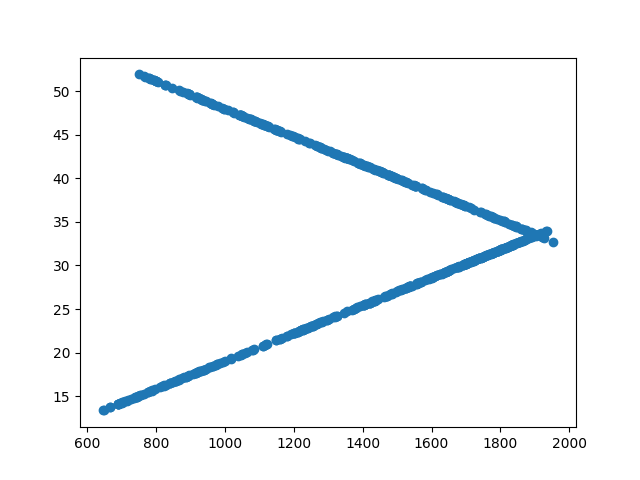

SystemExit: 

/home/rrazakami/work/ND-LAr/base/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [106]:
# plt.close('all')
main()